In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

%matplotlib inline

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
df = pd.read_csv('data/churn.csv')
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [4]:
df.shape

(50000, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [3]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
print df['last_trip_date'].max(),df['last_trip_date'].min()
print df['signup_date'].max(),df['signup_date'].min()

2014-07-01 00:00:00 2014-01-01 00:00:00
2014-01-31 00:00:00 2014-01-01 00:00:00


In [6]:
df['churn?'] = df['last_trip_date'] < '2014-06-01'

In [7]:
print df[df['phone'].isnull()]['churn?'].sum()
print df[df['phone'].isnull()].shape

263
(396, 13)


In [8]:
df['not_rate'] = df['avg_rating_of_driver'].isnull()
df['iphone?'] = df['phone'] == 'iphone'
df[df['city'].unique()] = pd.get_dummies(df['city'])

# Finish data conversion, some plotting

In [13]:
df_yes = df[df['churn?']==True]
df_no = df[df['churn?']==False]
print df_yes.shape, df_no.shape

(31196, 18) (18804, 18)


In [9]:
num_var = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct']
cat_var = ['city','phone','luxury_car_user'] #two are converted
boolean_var = ['luxury_car_user','not_rate','iphone?','Astapor','Winterfell',"King's landing"]
datetime_var = ['last_trip_date','signup_date']

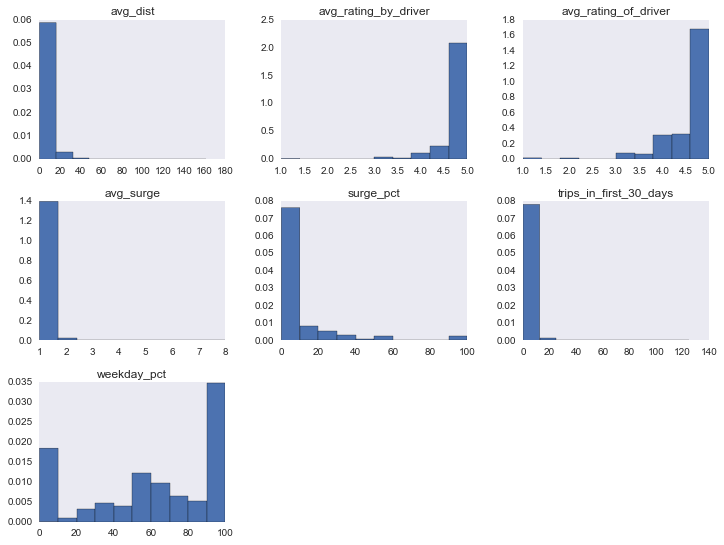

In [10]:
#check distribution of entire df, churn or no churn
df[num_var].hist(figsize=(12, 9), grid=False, normed=True);

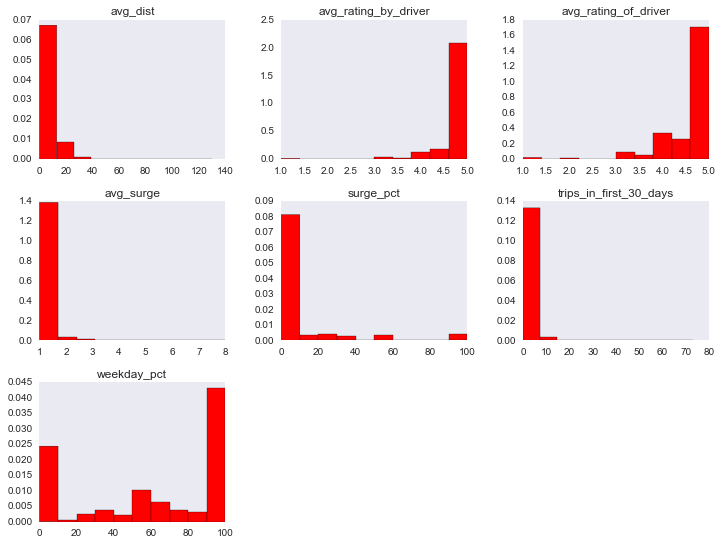

In [23]:
df_yes[num_var].hist(figsize=(12, 9), grid=False, color='red',normed=True);

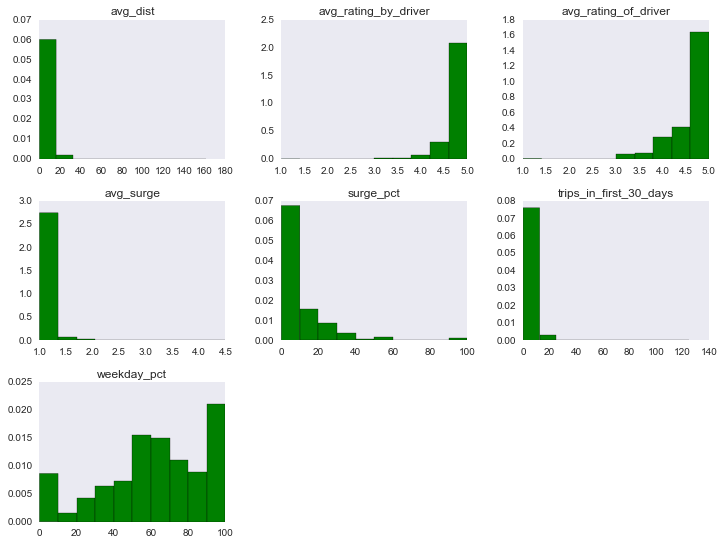

In [62]:
df_no[num_var].hist(figsize=(12, 9), grid=False, normed=True,color='green');

# Numerical variables

In [11]:
def plot_distplot(df1,df2,col,num=None):
    plt.figure(figsize=(12,6))
    sns.distplot(df1[col],label='Churn')
    sns.distplot(df2[col],label='No Churn')
    if num:
        plt.xlim([0,num])
    plt.legend()

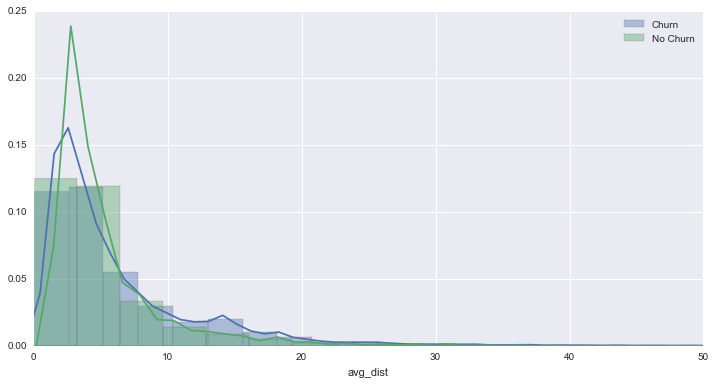

In [14]:
plot_distplot(df_yes,df_no,'avg_dist',50)

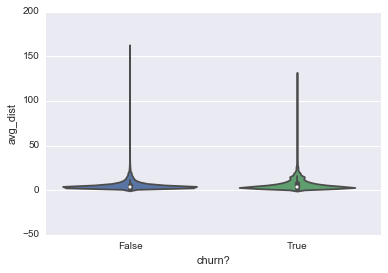

In [15]:
sns.violinplot(x='churn?',y='avg_dist',data=df)

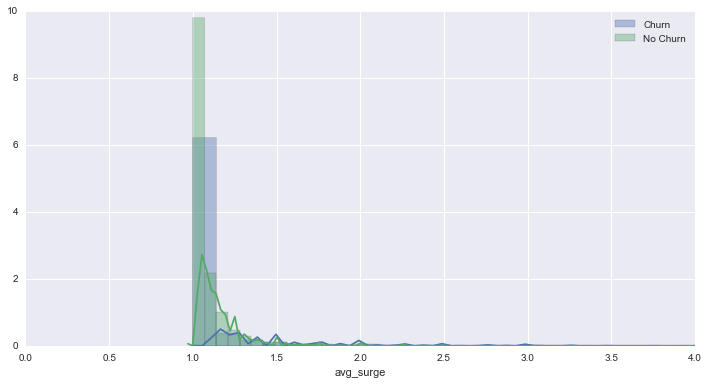

In [42]:
plot_distplot(df_yes,df_no,'avg_surge',4)

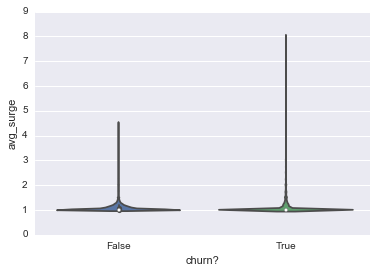

In [16]:
sns.violinplot(x='churn?',y='avg_surge',data=df)

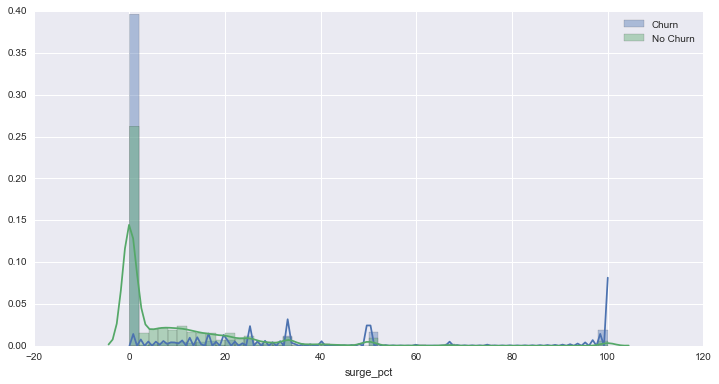

In [43]:
plot_distplot(df_yes,df_no,'surge_pct')

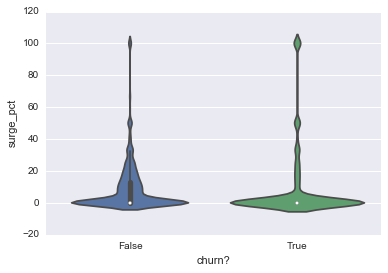

In [17]:
sns.violinplot(x='churn?',y='surge_pct',data=df)

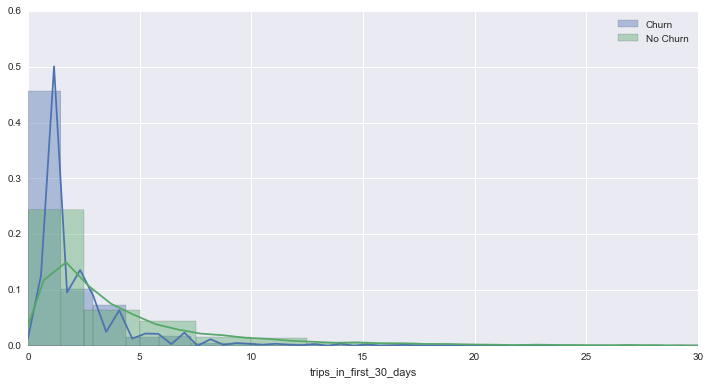

In [45]:
plot_distplot(df_yes,df_no,'trips_in_first_30_days',30)

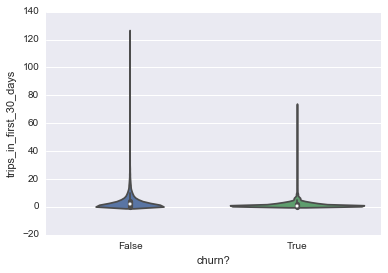

In [19]:
sns.violinplot(x='churn?',y='trips_in_first_30_days',data=df)

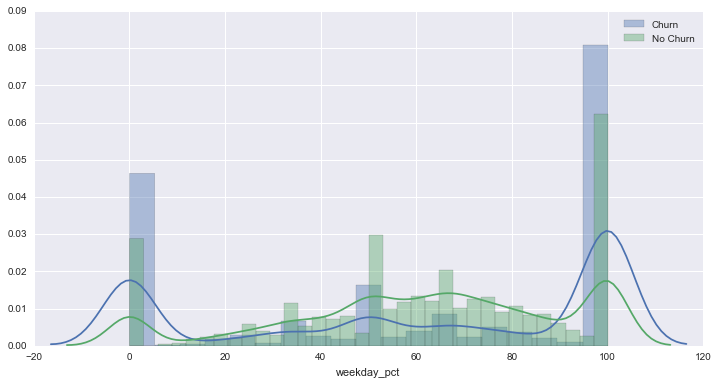

In [40]:
plot_distplot(df_yes,df_no,'weekday_pct')

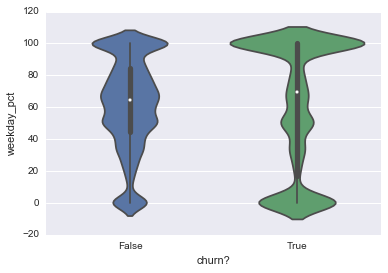

In [20]:
sns.violinplot(x='churn?',y='weekday_pct',data=df)

In [53]:
#modify function for rating, cannot do distplot,only kde
def plot_hisplot(df1,df2,col,num=None): 
    plt.figure(figsize=(12,6))
    sns.distplot(df1[col],label='Churn',hist=False)
    sns.distplot(df2[col],label='No Churn',hist=False)
    if num:
        plt.xlim([0,num])
    plt.legend()

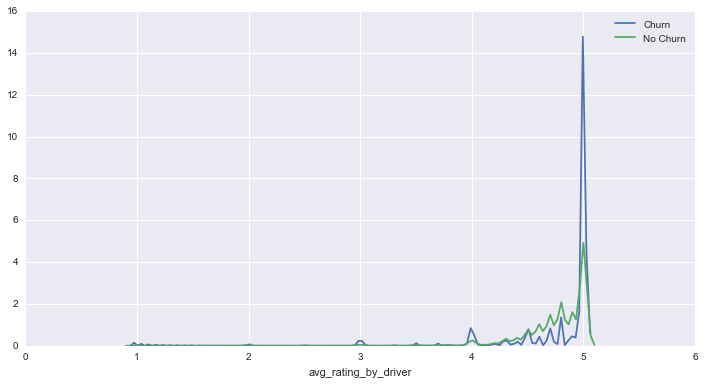

In [54]:
plot_hisplot(df_yes,df_no,'avg_rating_by_driver')

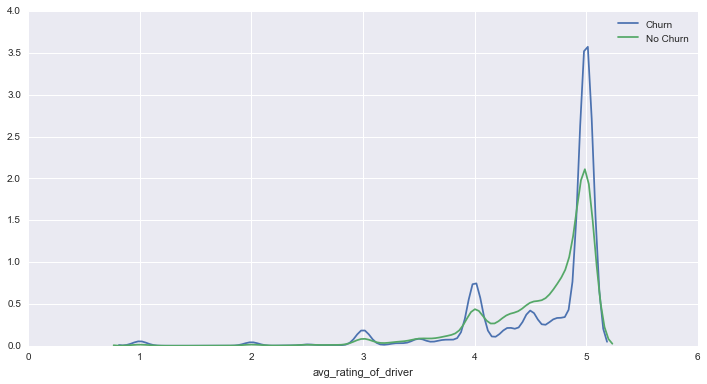

In [55]:
plot_hisplot(df_yes,df_no,'avg_rating_of_driver')

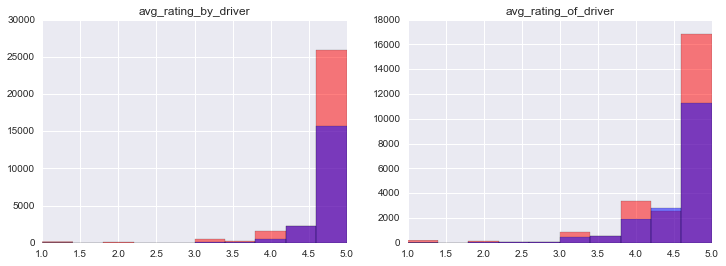

In [61]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
df_yes['avg_rating_by_driver'].hist(color ='r', alpha=0.5,ax=axes[0])
df_no['avg_rating_by_driver'].hist(color ='b', alpha=0.5,ax=axes[0])
axes[0].set_title('avg_rating_by_driver')
df_yes['avg_rating_of_driver'].hist(color ='r', alpha=0.5,ax=axes[1])
df_no['avg_rating_of_driver'].hist(color ='b', alpha=0.5,ax=axes[1])
axes[1].set_title('avg_rating_of_driver')

# Categorical variables

In [9]:
df.columns

Index([u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver',
       u'avg_surge', u'city', u'last_trip_date', u'phone', u'signup_date',
       u'surge_pct', u'trips_in_first_30_days', u'luxury_car_user',
       u'weekday_pct', u'churn?', u'not_rate', u'iphone?', u'King's Landing',
       u'Astapor', u'Winterfell'],
      dtype='object')

In [64]:
pd.crosstab(df['not_rate'],df['churn?'])

churn?,False,True
not_rate,,
False,17172,24706
True,1632,6490


In [66]:
pd.crosstab(df['luxury_car_user'],df['churn?'])

churn?,False,True
luxury_car_user,,
False,9307,21839
True,9497,9357


In [67]:
pd.crosstab(df['phone'],df['churn?'])

churn?,False,True
phone,,
Android,3146,11876
iPhone,15525,19057


In [68]:
pd.crosstab(df['city'],df['churn?'])

churn?,False,True
city,,
Astapor,4228,12306
King's Landing,6363,3767
Winterfell,8213,15123


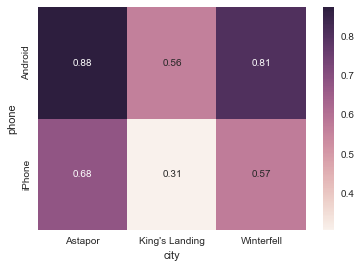

In [74]:
agg = df.groupby(['city','phone'])['churn?'].mean()
sns.heatmap(agg.unstack(level='city'), annot=True)

In [22]:
df[["King's Landing","Astapor", 'Winterfell']].head(10)

,King's Landing,Astapor,Winterfell
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,1.0,0.0,0.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


# Randomforest and feature selection

In [21]:
df.columns

Index([u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver',
       u'avg_surge', u'city', u'last_trip_date', u'phone', u'signup_date',
       u'surge_pct', u'trips_in_first_30_days', u'luxury_car_user',
       u'weekday_pct', u'churn?', u'not_rate', u'iphone?', u'King's Landing',
       u'Astapor', u'Winterfell'],
      dtype='object')

In [23]:
#select some promising columns based on plotting, also drop one city column
y=df['churn?']
cols_use = ['iphone?',"King's Landing","Astapor", 'trips_in_first_30_days', 'not_rate','luxury_car_user',\
        'surge_pct','weekday_pct','avg_dist','avg_surge']
cols_not =['avg_rating_of_driver','avg_rating_by_driver','Winterfell']
X = df[cols_use]

In [24]:
#use all features except rating becuase some are missing
RF_model = RandomForestClassifier(50)
RF_model.fit(X,y)
zip_feature = zip(cols_use, RF_model.feature_importances_)
print sorted(zip_feature, key = lambda x: x[1], reverse=True)
print np.mean(cross_val_score(RF_model, X, y, cv=5,scoring='accuracy'))
print np.mean(cross_val_score(RF_model, X, y, cv=5,scoring='recall'))

[('avg_dist', 0.43000127331540106), ('weekday_pct', 0.18061336251713314), ('surge_pct', 0.10032411765333971), ('avg_surge', 0.089126398204983165), ('trips_in_first_30_days', 0.086824190491481074), ('Astapor', 0.050791214780303309), ('luxury_car_user', 0.033725597711961618), ("King's Landing", 0.020152509749128099), ('not_rate', 0.0084413355762688828), ('iphone?', 0.0)]
0.727020036904
0.775419959642


In [25]:
#write a function to print feature importance and score
def prediction(model, df, cols, RF=None):
    y = df['churn?']
    X = df[cols]
    model.fit(X,y)
    
    if RF:
        print 'Model Importances\n'
        zip_feature = zip(cols, RF_model.feature_importances_)
        for item in sorted(zip_feature, key = lambda x: x[1], reverse=True):
            print item
        
    print 'Accuracy score:', np.mean(cross_val_score(model, X, y, cv=5, scoring = 'accuracy'))
    print "Recall score", np.mean(cross_val_score(model, X, y, cv=5, scoring = 'recall'))

In [26]:
#check all features except avg_dist
cols = [x for x in cols_use if x!='avg_dist']
rf1 = RandomForestClassifier(50)
prediction(rf1,df,cols,True)

Model Importances

('avg_surge', 0.43000127331540106)
('weekday_pct', 0.18061336251713314)
('surge_pct', 0.10032411765333971)
('trips_in_first_30_days', 0.086824190491481074)
('Astapor', 0.050791214780303309)
('luxury_car_user', 0.033725597711961618)
("King's Landing", 0.020152509749128099)
('not_rate', 0.0084413355762688828)
('iphone?', 0.0)
Accuracy score: 0.765680013069
Recall score 0.847544478282


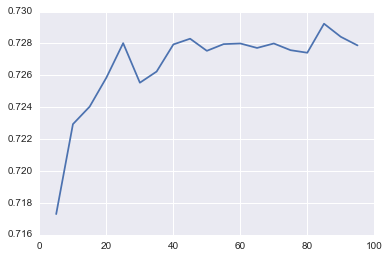

In [27]:
#check number of trees
num_trees = range(5, 100, 5)
accu=[]
for n in num_trees:
    rf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
    score = np.mean(cross_val_score(rf, X, y, cv=5, scoring = 'accuracy'))
    accu.append(score)
plt.plot(num_trees, accu)

In [28]:
#check average feature importance
def plot_avg_feature_importance(model,X,y,n,m,features):
    feat_arr = np.zeros((n, X.shape[1]))
    for i in xrange(n):
        model.fit(X,y)
        feat_arr[i,:] = model.feature_importances_

    fmean = feat_arr.mean(axis = 0)
    fstd = feat_arr.std(axis = 0)
    indices = np.argsort(fmean)[::-1][:m] #keep top m features
    sorted_fmean = fmean[indices][:m]
    sorted_fstd = fstd[indices][:m]
    sorted_fname = np.array(features)[indices][:m]
    for f in range(m):
        print("%d. %s (%f)" % (f + 1, sorted_fname[f], sorted_fmean[f]))

    fig = plt.figure(figsize=[12,6])
    plt.barh(range(m), sorted_fmean[::-1], color='r', \
                    xerr=sorted_fstd[::-1], align = 'center')
    plt.yticks(range(m), sorted_fname[::-1]);
    plt.ylim([-0.5,m-0.5])

1. avg_dist (0.429563)
2. weekday_pct (0.177240)
3. surge_pct (0.107648)
4. avg_surge (0.085572)
5. trips_in_first_30_days (0.085275)
6. Astapor (0.053051)
7. luxury_car_user (0.033961)
8. King's Landing (0.018961)
9. not_rate (0.008730)
10. iphone? (0.000000)


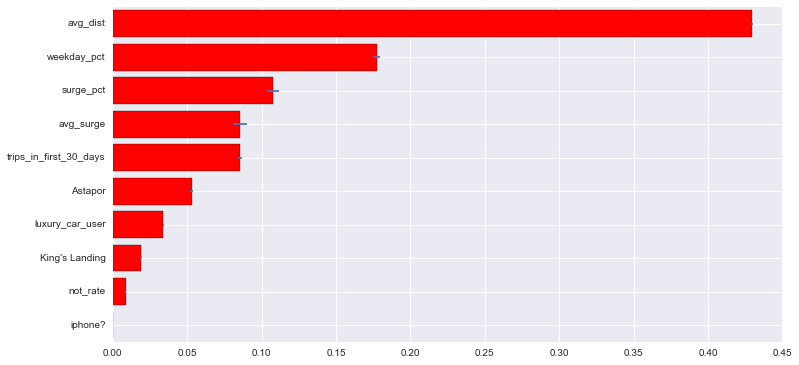

In [29]:
n = 20 #how many times to repeat
m = len(cols_use) #how many features to plot
#cols_use is features, X,y is the same
rf_avg = RandomForestClassifier(n_estimators=100)
plot_avg_feature_importance(rf_avg,X,y,n,m,cols_use)

In [30]:
def feature_substract(model,df,cols_total, cols_to_choose):
    y = df['churn?']
    scores =[]
    for col in cols_to_choose:
        temp_cols = [x for x in cols_total if x!=col]
        X = df[temp_cols]
        print 'Without ',col
        print 'Accuracy score: ',np.mean(cross_val_score(model, X, y, cv=5, scoring ='accuracy'))
        print 'Recall score: ',np.mean(cross_val_score(model, X, y, cv=5, scoring ='recall'))

In [31]:
rf_feature = RandomForestClassifier(n_estimators=100,n_jobs=-1)
cols_use = ['iphone?',"King's Landing","Astapor", 'trips_in_first_30_days', 'not_rate','luxury_car_user',\
        'surge_pct','weekday_pct','avg_dist','avg_surge']
cols_choose = ['avg_dist','avg_surge','iphone?','surge_pct','not_rate']

In [32]:
feature_substract(rf_feature,df,cols_use,cols_choose)
#only avg_dist has a big impact, remove it from cols_use

Without  avg_dist
Accuracy score:  0.767040043074
Recall score:  0.849467770969
Without  avg_surge
Accuracy score:  0.724500046897
Recall score:  0.772342764291
Without  iphone?
Accuracy score:  0.727680050906
Recall score:  0.776509913859
Without  surge_pct
Accuracy score:  0.721739998882
Recall score:  0.770451569121
Without  not_rate
Accuracy score:  0.725480072896
Recall score:  0.7721823589


In [33]:
#remove avg_dist from overall list, then check all the rest
cols_use = ['iphone?',"King's Landing","Astapor", 'trips_in_first_30_days', 'not_rate','luxury_car_user',\
        'surge_pct','weekday_pct','avg_surge']
cols_choose = cols_use
feature_substract(rf_feature,df,cols_use,cols_choose)

Without  iphone?
Accuracy score:  0.766520029074
Recall score:  0.847897062933
Without  King's Landing
Accuracy score:  0.766319999073
Recall score:  0.84991650433
Without  Astapor
Accuracy score:  0.753420021015
Recall score:  0.865784072275
Without  trips_in_first_30_days
Accuracy score:  0.759100093038
Recall score:  0.869470241985
Without  not_rate
Accuracy score:  0.765660017072
Recall score:  0.85373089458
Without  luxury_car_user
Accuracy score:  0.762320055056
Recall score:  0.849050914224
Without  surge_pct
Accuracy score:  0.757780053036
Recall score:  0.845300703597
Without  weekday_pct
Accuracy score:  0.746980078988
Recall score:  0.87357347393
Without  avg_surge
Accuracy score:  0.765540057073
Recall score:  0.853667012917


1. weekday_pct (0.323292)
2. surge_pct (0.197056)
3. avg_surge (0.159285)
4. trips_in_first_30_days (0.141263)
5. Astapor (0.084309)
6. luxury_car_user (0.053945)
7. King's Landing (0.028863)
8. not_rate (0.011987)
9. iphone? (0.000000)


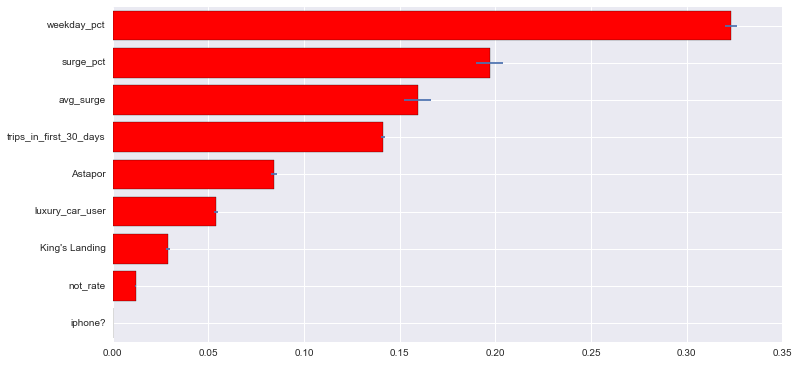

In [34]:
#none had major impact on score, check average importance again
n = 20 #how many times to repeat
m = len(cols_use) #how many features to plot
#cols_use is features
X = df[cols_use]
y = df['churn?']
rf_avg = RandomForestClassifier(n_estimators=100)
plot_avg_feature_importance(rf_avg,X,y,n,m,cols_use)

In [35]:
#remove the two with lowest importance
rf_test = RandomForestClassifier(n_estimators=100)
cols_test = [x for x in cols_use if x not in ['iphone?','not_rate']]

prediction(rf_test,df,cols_test,True)

Model Importances

('avg_surge', 0.10032411765333971)
('luxury_car_user', 0.086824190491481074)
('trips_in_first_30_days', 0.050791214780303309)
('weekday_pct', 0.033725597711961618)
('Astapor', 0.020152509749128099)
('surge_pct', 0.0084413355762688828)
("King's Landing", 0.0)
Accuracy score: 0.766160025076
Recall score 0.852929396764


# AdaBoost

In [36]:
y=df['churn?']
cols_use = ['iphone?',"King's Landing","Astapor", 'trips_in_first_30_days', 'not_rate','luxury_car_user',\
        'surge_pct','weekday_pct','avg_dist','avg_surge']
X=df[cols_use]

Ada_model = AdaBoostClassifier()
params = {'learning_rate':[1,0.3,0.1,0.03, 0.01]          
         }

grid_ada = GridSearchCV(AdaBoostClassifier(n_estimators=100), params, scoring='recall')
grid_ada.fit(X,y)
print grid_ada.best_score_
print grid_ada.best_params_

0.97967684956
{'learning_rate': 0.01}


In [37]:
best_ada = grid_ada.best_estimator_
prediction(best_ada,df,cols_use,True)

Model Importances

('avg_dist', 0.43000127331540106)
('weekday_pct', 0.18061336251713314)
('surge_pct', 0.10032411765333971)
('avg_surge', 0.089126398204983165)
('trips_in_first_30_days', 0.086824190491481074)
('Astapor', 0.050791214780303309)
('luxury_car_user', 0.033725597711961618)
("King's Landing", 0.020152509749128099)
('not_rate', 0.0084413355762688828)
('iphone?', 0.0)
Accuracy score: 0.671399942682
Recall score 0.97967674389


In [38]:
#change scoring to accuracy
grid_ada1 = GridSearchCV(AdaBoostClassifier(n_estimators=100), params, scoring='accuracy')
grid_ada1.fit(X,y)
print grid_ada1.best_score_
print grid_ada1.best_params_

0.76138
{'learning_rate': 1}


In [39]:
#with metrics=accuracy, similar score as randomforest
best_ada1 = grid_ada1.best_estimator_
prediction(best_ada1,df,cols_use,True)

Model Importances

('avg_dist', 0.43000127331540106)
('weekday_pct', 0.18061336251713314)
('surge_pct', 0.10032411765333971)
('avg_surge', 0.089126398204983165)
('trips_in_first_30_days', 0.086824190491481074)
('Astapor', 0.050791214780303309)
('luxury_car_user', 0.033725597711961618)
("King's Landing", 0.020152509749128099)
('not_rate', 0.0084413355762688828)
('iphone?', 0.0)
Accuracy score: 0.761460105053
Recall score 0.862129676436


In [40]:
#grid search for gradientboosting

def grid_search(est, grid):
    grid_cv = GridSearchCV(est, grid, n_jobs=-1, verbose=True,
                           scoring='recall').fit(X,y)
    return grid_cv


gd_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
           'max_depth': [4, 6],
           'min_samples_leaf': [3, 5, 9, 17],
           'max_features': [1.0, 0.3, 0.1],
           'n_estimators': [100]}
gd_grid_search = grid_search(GradientBoostingClassifier(), gd_grid)
gd_best = gd_grid_search.best_estimator_
gd_best.fit(X,y)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  6.8min finished


GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=4, max_features=0.1, max_leaf_nodes=None,
              min_samples_leaf=9, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [41]:
gd_grid_search.best_score_

0.94717271595555097

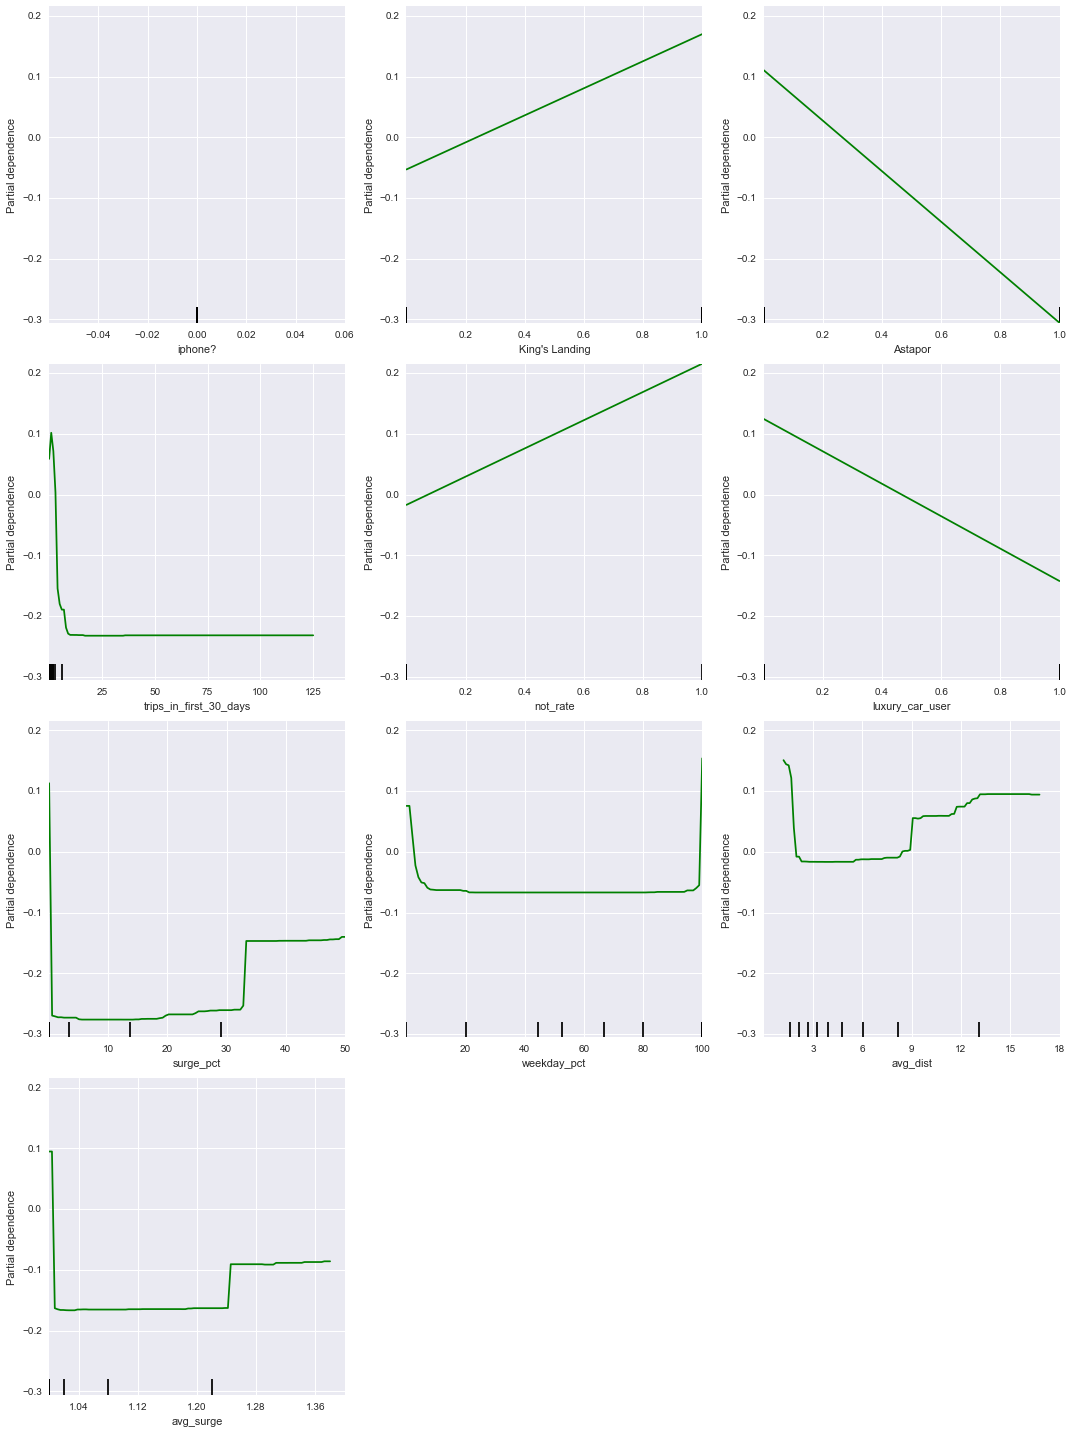

In [42]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
features = gd_best.feature_importances_
sorted_index = np.argsort(features)
fig, axs = plot_partial_dependence(gd_best, X, range(X.shape[1]) ,feature_names=cols_use, figsize=(15, 20))
fig.tight_layout()

# LogisticRegresion

In [43]:
model_lm = LogisticRegression()
#use cols_use for all ten features
prediction(model_lm,df,cols_use,False)

Accuracy score: 0.706200088847
Recall score 0.855013156489


In [44]:
for item in zip(cols_use, np.exp(model_lm.coef_)[0]):
    print item

('iphone?', 1.0)
("King's Landing", 1.6723186541653676)
('Astapor', 0.31134852827833287)
('trips_in_first_30_days', 0.89884049335647953)
('not_rate', 2.0794015708246305)
('luxury_car_user', 0.41187280688569144)
('surge_pct', 0.99631672442732944)
('weekday_pct', 1.0003127527128468)
('avg_dist', 1.0337792026899932)
('avg_surge', 1.1421520119571467)


# profit curve



In [45]:
def profit_curve(cb, predict_probas, labels):
    
    profits = []
    probas = np.sort(predict_probas)
    
    for prob in probas:
        predict = predict_probas > prob
        confusion = confusion_matrix(labels, predict)
        profits.append(np.sum(confusion*cb)/labels.shape[0])
    return profits

def confusion_matrix(y_true, y_predict):
    y_true = np.array(y_true)
    y_predict = np.array(y_predict)
    output = np.zeros((2,2))
    output[0,0]= np.sum((y_true==1) & (y_predict==1))
    output[0,1]= np.sum((y_true==0) & (y_predict==1))
    output[1,0]= np.sum((y_true==1) & (y_predict==0))
    output[1,1]= np.sum((y_true==0) & (y_predict==0))

    return output



In [46]:
def plot_profit_curve(model, label, costbenefit, X_train, X_test, y_train, y_test) :
    
    model.fit(X_train, y_train)
    probas_test = model.predict_proba(X_test)[:,1]
    profits = profit_curve(costbenefit, probas_test, y_test)
    
    percentages = np.arange(0, 100, 100. / len(profits))
    
    plt.plot(percentages, profits, label=label)
    
    plt.title("Profit Curve")
    plt.xlabel("Percentage of test instances (decreasing by score)")
    plt.ylabel("Profit")
    plt.legend(loc='lower right')


In [79]:
#p=0.5

#c_b = np.array([[p*15+(1-p)*(-5),15],[0,20]])
# 0.8*15+0.2*(-5)= 12-1=11


In [47]:
y = df['churn?']
X = df[cols_use]
X_train, X_test, y_train, y_test = train_test_split(X,y)
rf_model = RandomForestClassifier(100)
model_lm = LogisticRegression()
c_b = np.array([[10,-5],[0,0]]) #number 10 and -5 are just a guess

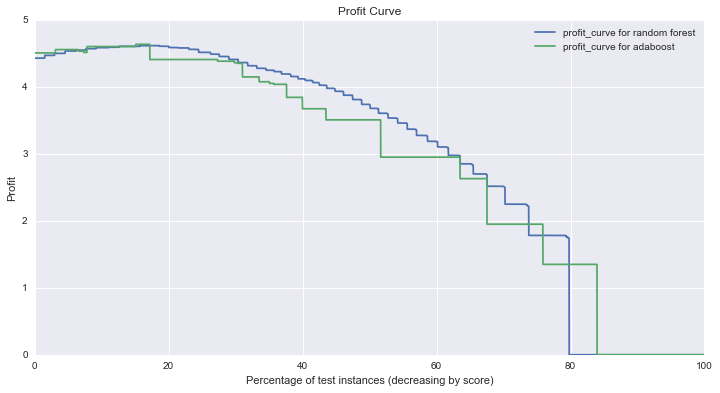

In [48]:

fig = plt.figure(figsize = (12,6))
plot_profit_curve(RF_model, 'profit_curve for random forest', c_b, X_train, X_test, y_train, y_test)
plot_profit_curve(best_ada, 'profit_curve for adaboost', c_b, X_train, X_test, y_train, y_test)
#plot_profit_curve(model_lm, 'profit_curve for Logistic', c_b, X_train, X_test, y_train, y_test)
plt.legend()

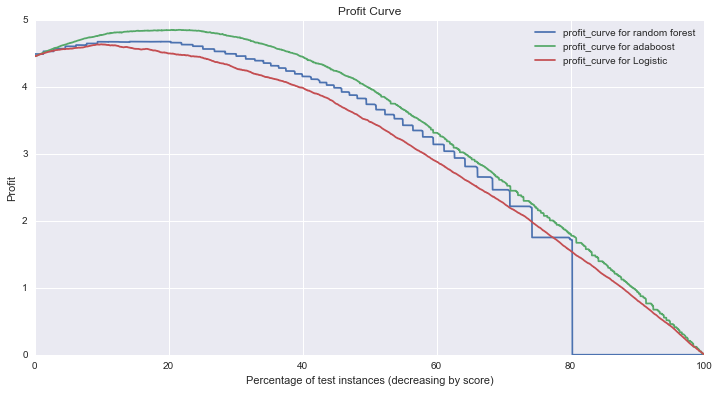

In [50]:
#convert datatype to float for logistic regression

y = df['churn?']
X = df[cols_use].values
X = X.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X,y)
rf_model = RandomForestClassifier(100)
model_lm = LogisticRegression()
c_b = np.array([[10,-5],[0,0]])
fig = plt.figure(figsize = (12,6))
plot_profit_curve(RF_model, 'profit_curve for random forest', c_b, X_train, X_test, y_train, y_test)
#use adaboost best_ada1 for different metrics
plot_profit_curve(best_ada1, 'profit_curve for adaboost', c_b, X_train, X_test, y_train, y_test)
plot_profit_curve(model_lm, 'profit_curve for Logistic', c_b, X_train, X_test, y_train, y_test)
plt.legend()

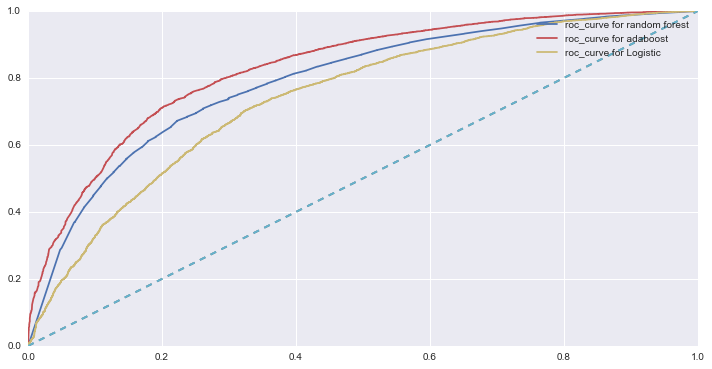

In [51]:
def plot_roc(model, label ,X_test,  y_test):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label=label)
    plt.plot([0,1],[0,1], linestyle='--')

fig = plt.figure(figsize = (12,6))
plot_roc(RF_model, 'roc_curve for random forest',  X_test, y_test)
plot_roc(best_ada1, 'roc_curve for adaboost', X_test, y_test)
plot_roc(model_lm, 'roc_curve for Logistic', X_test,  y_test)
plt.legend()